In [0]:
# Databricks-ready PySpark code for dataset: ott_user_behavior_1
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("OTT_Analytics").getOrCreate()

# ---------- 1) Load dataset (try Spark table, else CSV fallback) ----------
dataset_name = "ott_user_behavior_1"

try:
    df = spark.table(dataset_name)
    print(f"Loaded Spark table: {dataset_name}")
except Exception as e:
    print(f"Table {dataset_name} not found, trying CSV at /FileStore/tables/{dataset_name}.csv")
    df = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(f"/FileStore/tables/{dataset_name}.csv")

# quick clean / cast commonly-needed columns
# adjust column names if your schema differs (case-sensitive in Spark)
# Ensure numeric columns are numeric
num_cols = ["age", "avg_watch_time_per_day", "total_watch_time", "watch_duration",
            "completion_rate", "rating_given", "total_sessions_per_week",
            "avg_stream_quality", "network_speed_mbps", "buffering_count",
            "monthly_spend", "peak_watch_hour", "churn_flag"]
for c in num_cols:
    if c in df.columns:
        df = df.withColumn(c, col(c).cast(DoubleType()))

# Fill NA for numeric cols with 0 for safe model training (simple strategy)
numeric_present = [c for c in num_cols if c in df.columns]
df = df.fillna({c: 0.0 for c in numeric_present})

Loaded Spark table: ott_user_behavior_1


In [0]:
from pyspark.sql.functions import col, lit, least, greatest, explode
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS

# ✅ Load directly from catalog, not CSV
df = spark.table("workspace.default.ott_user_behavior_1")

✅ 'peak_watch_hour' column found.


peak_watch_hour,active_users,avg_stream_quality,avg_network_speed,avg_buffering
0,208,null,53.14,2.52
1,220,null,51.14,2.41
2,205,null,52.32,2.54
3,180,null,52.16,2.48
4,186,null,53.63,2.34
5,213,null,52.82,2.62
6,219,null,52.56,2.57
7,173,null,54.46,2.54
8,224,null,50.49,2.46
9,183,null,50.44,2.67


Databricks visualization. Run in Databricks to view.

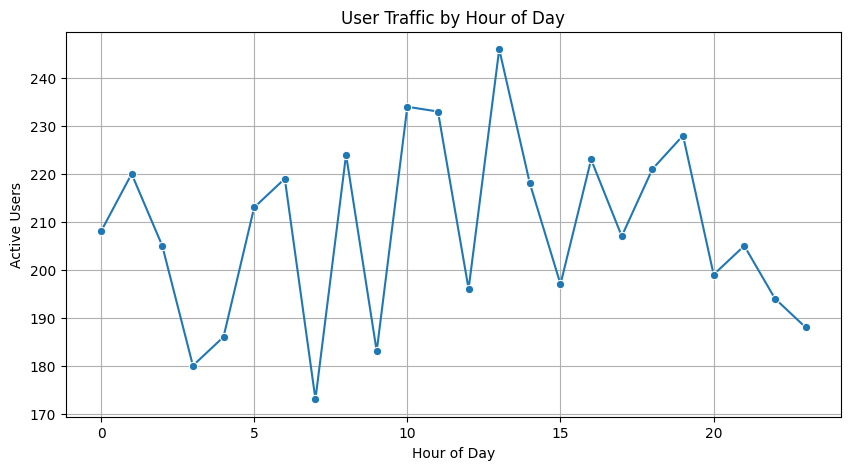

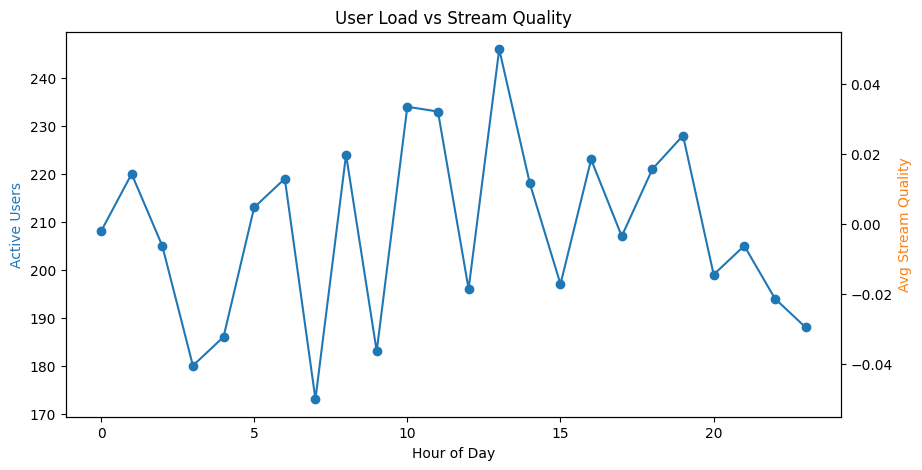

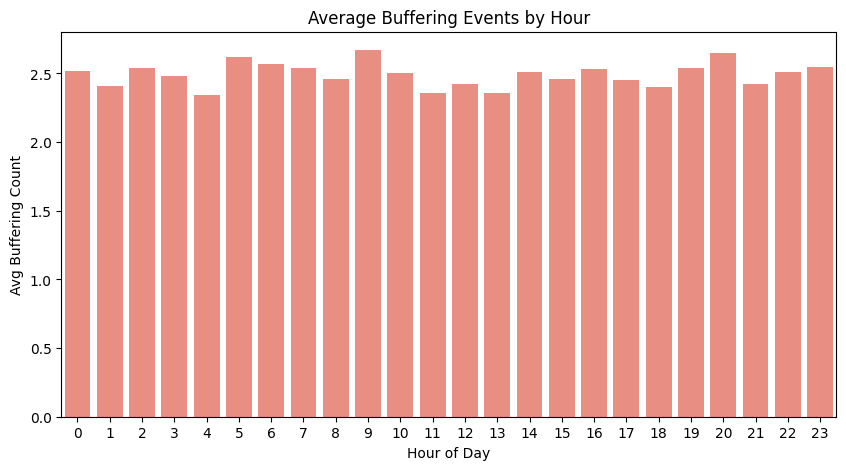

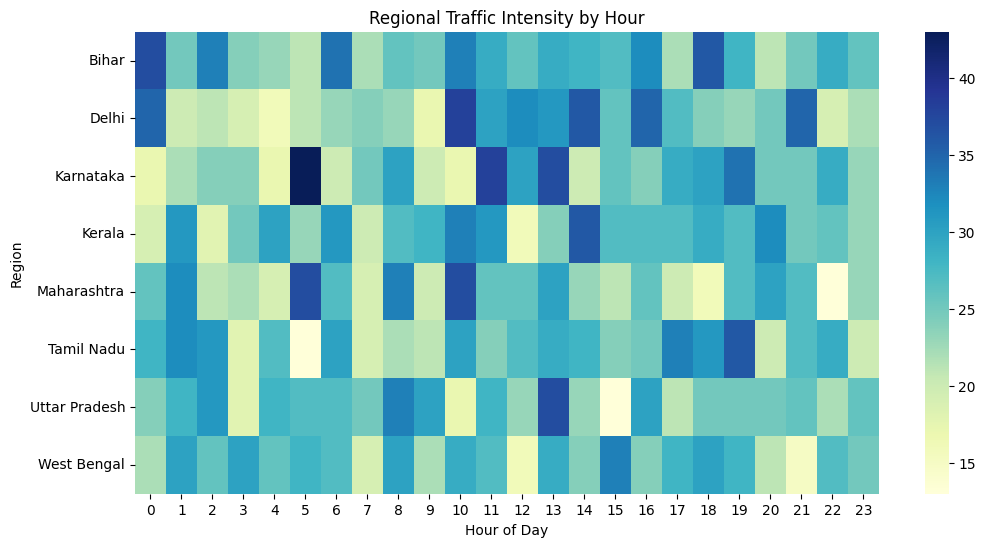

✅ peak_hours table written successfully.
✅ All available tables written successfully.


In [0]:
# ---------- Use Case 5: Peak Traffic and Load Optimization ----------

from pyspark.sql.functions import col, when, countDistinct, avg, round, hour
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'peak_watch_hour' exists
if "peak_watch_hour" not in df.columns:
    if "watch_date" in df.columns:
        df = df.withColumn("peak_watch_hour", hour(col("watch_date")))
    else:
        print("❌ 'peak_watch_hour' not in dataset and 'watch_date' missing. Skipping analysis.")
else:
    print("✅ 'peak_watch_hour' column found.")

# --- CLEANING: Convert non-numeric text values safely ---
for c in ["avg_stream_quality", "network_speed_mbps", "buffering_count"]:
    if c in df.columns:
        df = df.withColumn(
            c,
            when(col(c).rlike("^[0-9.]+$"), col(c).cast("double"))
            .otherwise(None)
        )

# --- AGGREGATION ---
if "peak_watch_hour" in df.columns:
    peak_hours = (
        df.groupBy("peak_watch_hour")
        .agg(
            countDistinct("user_id").alias("active_users"),
            round(avg("avg_stream_quality"), 2).alias("avg_stream_quality"),
            round(avg("network_speed_mbps"), 2).alias("avg_network_speed"),
            round(avg("buffering_count"), 2).alias("avg_buffering")
        )
        .orderBy("peak_watch_hour")
    )

    # Databricks visual (simple table view)
    display(peak_hours)

    # Convert to Pandas for matplotlib/seaborn visualization
    pdf = peak_hours.toPandas()

    # --- Visualization 1: Active Users Trend ---
    plt.figure(figsize=(10,5))
    sns.lineplot(x='peak_watch_hour', y='active_users', data=pdf, marker='o')
    plt.title("User Traffic by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Active Users")
    plt.grid(True)
    plt.show()

    # --- Visualization 2: Dual-Axis Chart (Users vs Stream Quality) ---
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(pdf['peak_watch_hour'], pdf['active_users'], color='tab:blue', marker='o', label='Active Users')
    ax2.plot(pdf['peak_watch_hour'], pdf['avg_stream_quality'], color='tab:orange', marker='x', label='Avg Stream Quality')

    ax1.set_xlabel("Hour of Day")
    ax1.set_ylabel("Active Users", color='tab:blue')
    ax2.set_ylabel("Avg Stream Quality", color='tab:orange')
    plt.title("User Load vs Stream Quality")
    plt.show()

    # --- Visualization 3: Avg Buffering by Hour (Bar Chart) ---
    plt.figure(figsize=(10,5))
    sns.barplot(x='peak_watch_hour', y='avg_buffering', data=pdf, color='salmon')
    plt.title("Average Buffering Events by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Buffering Count")
    plt.show()

# --- Optional Visualization 4: Heatmap (Region vs Hour) ---
if "region" in df.columns:
    region_hour = (df.groupBy("region", "peak_watch_hour")
                    .agg(countDistinct("user_id").alias("active_users"))
                    .toPandas())

    # Correct pandas pivot syntax
    heatmap_data = region_hour.pivot(
        index="region", 
        columns="peak_watch_hour", 
        values="active_users"
    ).fillna(0)
    
    plt.figure(figsize=(12,6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)
    plt.title("Regional Traffic Intensity by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Region")
    plt.show()

else:
    print("⚠️ 'peak_watch_hour' not found — please verify column name or source data.")

# ---------- Optional: Save Delta Tables for Dashboard ----------
try:
    # Only save tables that were created in THIS use case
    if 'peak_hours' in locals():
        peak_hours.write.mode("overwrite").format("delta").saveAsTable("ott_peak_traffic_summary")
        print("✅ peak_hours table written successfully.")
    
    # Optional: Check and save other tables if they exist from previous use cases
    if 'viewing_pattern' in locals():
        viewing_pattern.write.mode("overwrite").format("delta").saveAsTable("ott_viewing_pattern_summary")
        print("✅ viewing_pattern table written successfully.")
    
    if 'recs_with_ids' in locals():
        recs_with_ids.write.mode("overwrite").format("delta").saveAsTable("ott_recommendations")
        print("✅ recs_with_ids table written successfully.")
    
    if 'churn_preds' in locals():
        churn_preds.write.mode("overwrite").format("delta").saveAsTable("ott_churn_predictions")
        print("✅ churn_preds table written successfully.")

    if 'regional_demand' in locals():
        regional_demand.write.mode("overwrite").format("delta").saveAsTable("ott_regional_demand")
        print("✅ regional_demand table written successfully.")

    print("✅ All available tables written successfully.")
    
except Exception as e:
    print(f"⚠️ Table write error: {e}")